# Data Augmentation with the Cifar-100 Classification

Training data (50000, 32, 32, 3)
Training label (50000, 1)
Max number of training label 99


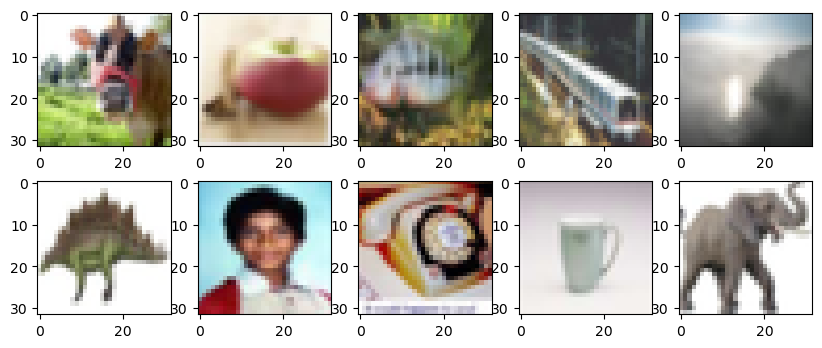

In [1]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
print(f"Training data {x_train.shape}")
print(f"Training label {y_train.shape}")
print(f"Max number of training label {np.max(y_train)}")

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for index, img in enumerate(x_train[0:10]):
    axs[index%2, int(index/2)].imshow(img, cmap="gray_r")


## Option 1: Create an augmentation network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers import RandomFlip, RandomRotation
from keras.regularizers import L2

# Picking some Layers from https://keras.io/api/layers/preprocessing_layers/image_augmentation/
augmentation = Sequential(name="augmentation")
augmentation.add(RandomRotation(0.2, input_shape=(32, 32, 3)))
augmentation.add(RandomFlip("horizontal"))

augmented_imgs = augmentation(x_train[0:10]/255)
# Warnings will be produced you can ignore them

In [ ]:
# Plot augmented pictures
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for index, img in enumerate(augmented_imgs):
    axs[index%2, int(index/2)].imshow(img, cmap="gray_r")


This augmentation network can be used inside another Sequencial network similar like a regular layer. Thus networks can be nested. 

In [ ]:
nestedModel = Sequential()
nestedModel.add(augmentation);
nestedModel.add(Flatten())
nestedModel.add(Dense(100, activation="sigmoid"))
nestedModel.add(Dense(100, activation="softmax"))
nestedModel.summary()

## Alternative Way: Using an Image Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

imageGenerator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20
)

In [ ]:
#x_train.shape
imageGenerator.fit(x_train[0:10])
iterator = imageGenerator.flow(x_train, y_train, shuffle=False, batch_size=10)

In [ ]:
imgs, ys = iterator.next()
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for index, img in enumerate(imgs):
    axs[index%2, int(index/2)].imshow(img, cmap="gray_r")


    # if we execute this more often we will get different pictures from the generator

## An overfitting Convnet

Results after 10 Epochs, 100 Iterations of 500 Samples:<br>
50/50 - 6s 112ms/step - <b>accuracy: 0.91</b> - <b>val_accuracy: 0.22</b>


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.regularizers import L2

def createCNN():
    model = Sequential()

    model.add(BatchNormalization(input_shape=(32, 32, 3)))
    model.add(Conv2D(20, kernel_size=(3, 3), input_shape=(32, 32, 3)))
    model.add(Conv2D(10, kernel_size=(3, 3), activation="relu"))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(150, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(100, activation="softmax"))

    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
model = createCNN()
model.fit(
    x_train, 
    y_train, 
    validation_data = (x_test, y_test),
    epochs=10, 
    batch_size=500)

## Now with ImageDataGenerator - Augmentation

Result without augmentation        
Epoch 10 Iteration 100 Batchsize 500<br>
loss: 0.3803 - <b>accuracy: 0.9400</b> - val_loss: 4.4131 - val_accuracy: <b>0.2145</b><br>
<br>
<br>
Result with augmentation<br>
Epoch 10 Iteration 100 BatchSize 500<br>
loss: 2.4029 - <b>accuracy: 0.3980</b> - val_loss: 2.7793 - val_accuracy: <b>0.3218</b><br>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = createCNN()

imageGenerator = ImageDataGenerator(
    #rescale=1./255,
    horizontal_flip=True,
    rotation_range=20
)
imageGenerator.fit(x_train)

it = imageGenerator.flow(x_train, y_train, shuffle=False, batch_size=500);
for epoch in range(10):
    for iteration in range(100):
        X, y = it.next()
        print(f"Epoch {epoch+1} Iteration {iteration+1}")
        model.fit(X, y, 
                  validation_data= (x_test, y_test),
                  batch_size=500, 
                  epochs=1)
                

## Simplified code using the generator in the fit-Function

In [ ]:
# Note .... this did not work as expected, so the manual training loop was presented first. 

# But usually it should work like this:
# fits the model on batches with real-time data augmentation:
model.fit(imageGenerator.flow(x_train, y_train, shuffle=True, batch_size=500),
        validation_data = (x_test, y_test),
        epochs=10,         
        steps_per_epoch=100)